In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
import pandas as pd
import numpy as np

In [11]:
df = pd.read_csv('/content/drive/MyDrive/Trumptweets/trum_tweet_sentiment_analysis.csv')

In [12]:
df.head()

,text,Sentiment
0,RT @JohnLeguizamo: #trump not draining swamp b...,0
1,ICYMI: Hackers Rig FM Radio Stations To Play A...,0
2,Trump protests: LGBTQ rally in New York https:...,1
3,"""Hi I'm Piers Morgan. David Beckham is awful b...",0
4,RT @GlennFranco68: Tech Firm Suing BuzzFeed fo...,0


In [13]:
df.dropna()

,text,Sentiment
0,RT @JohnLeguizamo: #trump not draining swamp b...,0
1,ICYMI: Hackers Rig FM Radio Stations To Play A...,0
2,Trump protests: LGBTQ rally in New York https:...,1
3,"""Hi I'm Piers Morgan. David Beckham is awful b...",0
4,RT @GlennFranco68: Tech Firm Suing BuzzFeed fo...,0
...,...,...
1850118,Everytime im like 'How the fuck I follow Melan...,0
1850119,RT @imgur: The Trump Handshake. https://t.co/R...,0
1850120,"""Greenspan warns Trump's policies risk inflati...",0
1850121,RT @FasinatingLogic: We must also #INVESTIGATE...,1


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Dropout
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [15]:
def text_cleaning_pipeline(dataset, rule = "lemmatize"):
  """
  This...
  """
  # Convert the input to small/lower order.
  data = dataset.lower()
  # Remove URLs
  data = re.sub(r"http\S+|www\S+|https\S+", '',data, flags=re.MULTILINE)
  # Remove emojis
  data = re.sub(r"["
                        u"\U0001F600-\U0001F64F"  # emoticons
                        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                        u"\U0001F680-\U0001F6FF"  # transport & map symbols
                        u"\U0001F1E0-\U0001F1FF"  # flags
                        u"\u2702-\u27B0"          # dingbats
                        u"\u24C2-\U0001F251"      # enclosed characters
                        "]+",
                        r' ', data, flags=re.UNICODE)
  # Remove mentions
  data = re.sub("@[A-Za-z0-9_]+"," ", data)
  # Remove all other unwanted characters.
  data = re.sub("[^0-9A-Za-z ]", "" , data)
  # Create tokens.
  tokens = data.split()
  # Remove stopwords:
  stop_words = set(stopwords.words('english'))
  result_tokens = []
  for token in tokens:
    if token not in stop_words:
      result_tokens.append(token)
  if rule == "lemmatize":
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in result_tokens]
  elif rule == "stem":
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in result_tokens]
  else:
    print("Pick between lemmatize or stem")


  return " ".join(tokens)

In [16]:
df['clean_text'] = df['text'].apply(lambda x: text_cleaning_pipeline(x, rule="lemmatize"))

In [17]:
X = df['clean_text']
y = df['Sentiment']

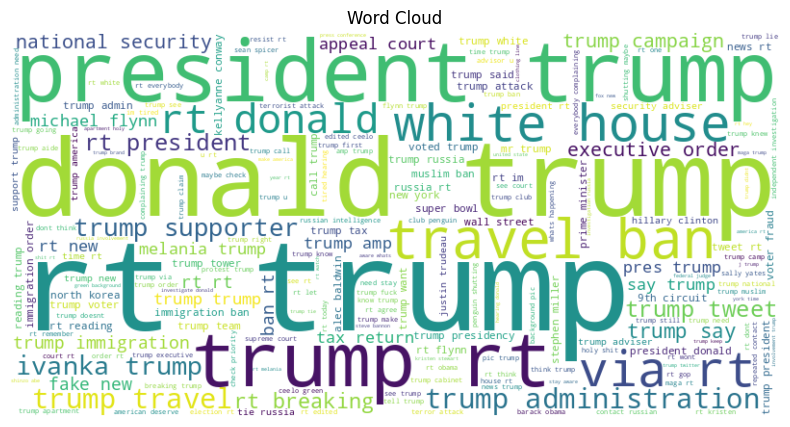

In [18]:
from wordcloud import WordCloud
all_clean_text = " ".join(df['clean_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_clean_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud")
plt.show()

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")

tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_length = max([len(x) for x in X_train_seq])
print(max_length)


28


In [21]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense

X_train_padded = pad_sequences(X_train_seq, padding='post', maxlen=28)
X_test_padded = pad_sequences(X_test_seq, padding='post', maxlen=28)

rnn_model = Sequential()
rnn_model.add(Embedding(input_dim=10000, output_dim=128))
rnn_model.add(SimpleRNN(64))
rnn_model.add(Dense(1, activation='sigmoid'))

rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

rnn_model.build(input_shape=(None, 28))
rnn_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 28, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,292,417 (4.93 MB)

 Trainable params: 1,292,417 (4.93 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=10000, output_dim=128))
lstm_model.add(LSTM(64))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.build(input_shape=(None, 28))
lstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 28, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,329,473 (5.07 MB)

 Trainable params: 1,329,473 (5.07 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')

rnn_history = rnn_model.fit(
    X_train_padded, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_test_padded, y_test),
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/10
23127/23127 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9141 - loss: 0.2155

23127/23127 ━━━━━━━━━━━━━━━━━━━━ 120s 5ms/step - accuracy: 0.9141 - loss: 0.2155 - val_accuracy: 0.9540 - val_loss: 0.1306
Epoch 2/10
23127/23127 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9593 - loss: 0.1184

23127/23127 ━━━━━━━━━━━━━━━━━━━━ 112s 5ms/step - accuracy: 0.9593 - loss: 0.1184 - val_accuracy: 0.9593 - val_loss: 0.1253
Epoch 3/10
23127/23127 ━━━━━━━━━━━━━━━━━━━━ 142s 5ms/step - accuracy: 0.9641 - loss: 0.1069 - val_accuracy: 0.9530 - val_loss: 0.1361
Epoch 4/10
23120/23127 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9655 - loss: 0.1038

23127/23127 ━━━━━━━━━━━━━━━━━━━━ 142s 5ms/step - accuracy: 0.9655 - loss: 0.1038 - val_accuracy: 0.9593 - val_loss: 0.1208
Epoch 5/10
23127/23127 ━━━━━━━━━━━━━━━━━━━━ 142s 5ms/step - accuracy: 0.9647 - loss: 0.1049 - val_accuracy: 0.9568 - val_loss: 0.1276
Epoch 6/10
23127/23127 ━━━━━━━━━━━━━━━━━━━━ 148s 5ms/step - accuracy: 0.9637 - loss: 0.1080 - val_accuracy: 0.9548 - val_loss: 0.1326
Epoch 7/10
23127/23127 ━━━━━━━━━━━━━━━━━━━━ 141s 5ms/step - accuracy: 0.9597 - loss: 0.1190 - val_accuracy: 0.9487 - val_loss: 0.1491
Epoch 8/10
23127/23127 ━━━━━━━━━━━━━━━━━━━━ 117s 5ms/step - accuracy: 0.9540 - loss: 0.1337 - val_accuracy: 0.9467 - val_loss: 0.1540


In [24]:
lstm_history = lstm_model.fit(
    X_train_padded, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_test_padded, y_test),
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/10
23118/23127 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9207 - loss: 0.1978

23127/23127 ━━━━━━━━━━━━━━━━━━━━ 160s 7ms/step - accuracy: 0.9207 - loss: 0.1977 - val_accuracy: 0.9610 - val_loss: 0.1117
Epoch 2/10
23118/23127 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9666 - loss: 0.0950

23127/23127 ━━━━━━━━━━━━━━━━━━━━ 197s 7ms/step - accuracy: 0.9666 - loss: 0.0950 - val_accuracy: 0.9679 - val_loss: 0.0933
Epoch 3/10
23118/23127 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9748 - loss: 0.0728

23127/23127 ━━━━━━━━━━━━━━━━━━━━ 202s 7ms/step - accuracy: 0.9748 - loss: 0.0728 - val_accuracy: 0.9703 - val_loss: 0.0872
Epoch 4/10
23123/23127 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9794 - loss: 0.0596

23127/23127 ━━━━━━━━━━━━━━━━━━━━ 206s 7ms/step - accuracy: 0.9794 - loss: 0.0596 - val_accuracy: 0.9724 - val_loss: 0.0835
Epoch 5/10
23127/23127 ━━━━━━━━━━━━━━━━━━━━ 200s 7ms/step - accuracy: 0.9830 - loss: 0.0492 - val_accuracy: 0.9721 - val_loss: 0.0854
Epoch 6/10
23127/23127 ━━━━━━━━━━━━━━━━━━━━ 202s 7ms/step - accuracy: 0.9857 - loss: 0.0414 - val_accuracy: 0.9721 - val_loss: 0.0886
Epoch 7/10
23127/23127 ━━━━━━━━━━━━━━━━━━━━ 203s 7ms/step - accuracy: 0.9878 - loss: 0.0356 - val_accuracy: 0.9722 - val_loss: 0.0919
Epoch 8/10
23127/23127 ━━━━━━━━━━━━━━━━━━━━ 201s 7ms/step - accuracy: 0.9896 - loss: 0.0304 - val_accuracy: 0.9721 - val_loss: 0.0948


In [25]:
rnn_model.save('rnn_model.h5')

lstm_model.save('lstm_model.h5')

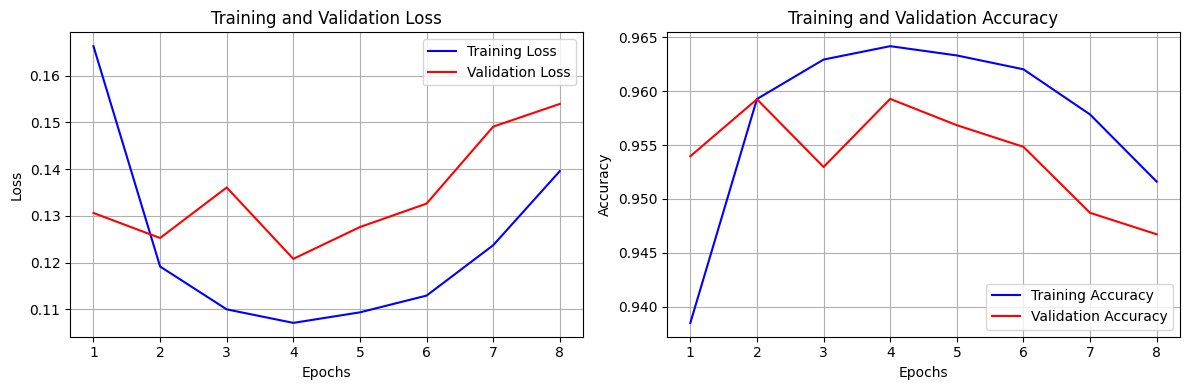

In [37]:
import matplotlib.pyplot as plt

# Extract history data
history_dict = rnn_history.history
epochs = range(1, len(history_dict['loss']) + 1)
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# Plotting
plt.figure(figsize=(12, 4))

# Plot 1: Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


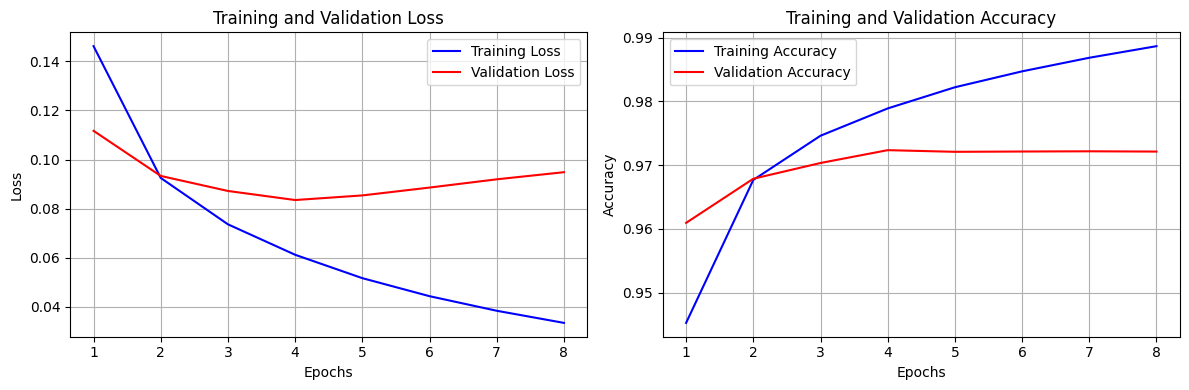

In [38]:
import matplotlib.pyplot as plt

# Extract history data from the LSTM model
history_dict = lstm_history.history
epochs = range(1, len(history_dict['loss']) + 1)
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# Plotting
plt.figure(figsize=(12, 4))

# Plot 1: Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [41]:
from sklearn.metrics import classification_report

lstm_preds = lstm_model.predict(X_test_padded)
rnn_preds = rnn_model.predict(X_test_padded)

lstm_preds_labels = (lstm_preds > 0.5).astype(int)
rnn_preds_labels = (rnn_preds > 0.5).astype(int)

y_test_labels = y_test

print("🔷 LSTM Classification Report:")
print(classification_report(y_test_labels, lstm_preds_labels))

print("🔷 RNN Classification Report:")
print(classification_report(y_test_labels, rnn_preds_labels))

11564/11564 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step
11564/11564 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step
🔷 LSTM Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98    248563
           1       0.96      0.95      0.96    121462

    accuracy                           0.97    370025
   macro avg       0.97      0.97      0.97    370025
weighted avg       0.97      0.97      0.97    370025

🔷 RNN Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97    248563
           1       0.95      0.93      0.94    121462

    accuracy                           0.96    370025
   macro avg       0.96      0.95      0.95    370025
weighted avg       0.96      0.96      0.96    370025



In [43]:
from IPython.display import display
import ipywidgets as widgets
import re
import string

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Sample dataset of tweets (positive and negative sentiment)
tweets = [
    ("I love America and its people!", 1),
    ("This administration is doing great work.", 1),
    ("Fake news is spreading lies about me.", 0),
    ("The economy is booming like never before!", 1),
    ("Corrupt politicians are ruining our country.", 0),
    ("We will make America great again!", 1),
    ("The media hates me because I tell the truth.", 0),
    ("Our military is stronger than ever.", 1),
    ("Crooked Hillary is a disgrace to politics.", 0),
    ("Together, we can achieve greatness.", 1)
]

# Separate tweets and labels
texts, labels = zip(*tweets)

# Clean text function
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#','', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    text = text.strip()
    return text

# Preprocess the tweets
cleaned_texts = [clean_text(text) for text in texts]

# Create TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=1000)
X = tfidf.fit_transform(cleaned_texts)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# Train a Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print(f"Model Accuracy: {accuracy_score(y_test, y_pred):.2%}")

# Create widgets
text_input = widgets.Textarea(
    placeholder="Paste Trump tweet here...",
    layout={'width': '500px', 'height': '100px'}
)
analyze_btn = widgets.Button(description="Analyze Sentiment", button_style='success')
output = widgets.Output()

def on_analyze_click(b):
    with output:
        output.clear_output()
        text = text_input.value
        if not text.strip():
            print("⚠️ Please enter a tweet!")
            return

        cleaned_text = clean_text(text)
        text_vector = tfidf.transform([cleaned_text])
        prediction = model.predict(text_vector)[0]
        # RandomForest may not return predict_proba with very small data, handle gracefully
        if hasattr(model, "predict_proba"):
            confidence = max(model.predict_proba(text_vector)[0])
            print(f"Confidence: {confidence:.2%}")
        else:
            confidence = "Unavailable"

        sentiment = "👍 POSITIVE" if prediction == 1 else "👎 NEGATIVE"
        print(f"RESULT: {sentiment}")

analyze_btn.on_click(on_analyze_click)

display(widgets.VBox([
    widgets.Label("Trump Tweet Sentiment Analysis:"),
    text_input,
    analyze_btn,
    output
]))

Model Accuracy: 50.00%
